# Survival analysis with GNN and Cox Model
In this notebook, we implement the whole pipeline to make survival analysis with Cox Model and GNN.

## Table of contents

0. [Reading dataset, drop censored patients, and label patients](#0-reading-dataset-and-drop-censored-patients)
1. [Leave one out cross validation to predict test risk classes](#1-leave-one-out-cv)
2. [Estimate survival metrics for each risk class](#2-evaluation)

## Pipeline description

0. [Reading dataset, drop censored patients, and label patients](#0-reading-dataset-and-drop-censored-patients)

For each step of the leave one out cross validation :

1. [Training process](#1-training-process)
    1. [Build the graph](#1-build-the-graph)
    2. [Train the GNN for binary survival classification](#2-train-gnn)
    3. [Extract learnt patients embeddings](#3-extract-learnt-patients-embeddings)
    4. [Train the Cox Model with new patients embeddings](#4-train-cox-model-with-new-embeddings)
2. [Testing process](#1-testing-process)
    1. [Add test patient to the graph](#1-add-test-patients-to-the-graph)
    2. [Make the GNN embedding prediction](#2-make-gnn-prediction)
    3. [Make the Cox Model prediction to predict test risk class](#3-make-cox-model-prediction)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.BuildGraph import BuildGraph
from models.GCNClassifier import GCNClassifier
from manage.GCNTrainTestManager import GCNTrainTestManager
from models.CoxModel import CoxModel
from sklearn.model_selection import KFold 
from torch_geometric.utils import from_networkx

## 0. Reading dataset and drop censored patients
We use the dataset from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163. We drop the non naive patients.

In [10]:
df = pd.read_excel('data/Supplemental-table1.xlsx')

# Delete non naive patients
df = df.loc[df["Cohort"] == "Naive"]

df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


### Delete censored patients
In statistics, some patients can have non faithful metrics, because of leaving the study for example. In our context, we want to drop patients which have not experienced an event (status = 0) and where the time of event is less than a given time t (which represents the time when we look at). Indeed, it might represent a precocious leaving of the patient ; what happened between the time of leaving and the time t when we look at ?

In [11]:
def drop_censored_patients(df: pd.DataFrame, status_name: str, time_name: str, t: float)->pd.DataFrame:
    """ 
    Delete censored patients from the initial dataframe. A censored patient is a patient with status = 0 and time_event < t.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe without censored patients.
    """

    # Get index of to drop patients
    to_drop = df.index[np.where((df[status_name] == 0) & (df[time_name]<t))[0]]
    print(f"{to_drop.shape[0]} patients censored deleted")

    # Update dataframe
    df_non_censored = df.drop(to_drop,axis=0)

    return df_non_censored

In [12]:
## TTP (Time To Progression)
t_ttp = np.median(df["Time to progression (days)"].to_numpy())
df_ttp_non_censored = drop_censored_patients(df, "Progression_1", "Time to progression (days)", t_ttp)

## OS (Overall survival)
t_os = np.median(df["Overall survival (days)"].to_numpy())
df_os_non_censored = drop_censored_patients(df, "Alive_0", "Overall survival (days)", t_os)

6 patients censored deleted
1 patients censored deleted


### Label patients for future classification
Now, we want to create a label column to split event occured patients and no event occured patients : 
- status = 1 and time < t : class 1 (the event occured)
- status = 1 and time > t : class 0 (the event has not occured yet at the time when we look at. The event will occur later)
- status = 0 and time > t : class 0 (the event has not occured at the time when we look at)
- status = 0 and time < t : censored patients, we already dropped these patients.

Because we already dropped censored patients, we can see that we just have to test if time < t. If yes, we label 1, otherwise, we label 0.

In [13]:
def label_patients(df: pd.DataFrame, time_name: str, t: float)->pd.DataFrame:
    """ 
    Create new column in dataframe with event label depending on status, time and t values.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe with an extra label column.
    """
    
    # We test if time < t (1 if yes, 0 otherwise)
    df["event_occured"] = np.where(df[time_name]<t, 1, 0)
    
    return df

In [14]:
## TTP :
df_ttp_non_censored = label_patients(df_ttp_non_censored, "Time to progression (days)",t_ttp)

## OS :
df_os_non_censored = label_patients(df_os_non_censored, "Overall survival (days)",t_os)

## 1. Leave one out cross validation
We split our dataframe in n_samples groups, where the train set contains all patients except one, and the test is the remaining patient. For each step of the leave one out cross validation, we begin with building the train graph, next we train the GNN with the binary survival classification to estimate new train embeddings of patients, and then we use these embeddings to train the Cox Model to estimate risk score. After the training, we rebuild the graph with the train and the test set, and we make a forward pass for the test patient to predict its risk class (high risk or low risk).

### Leave one out cross validation function

In [15]:
def leave_one_out_cross_validation(df: pd.DataFrame, column_name: str, features_name: list[str], label_name: str, n_epoch: int):
    """ 
    Make the leave one out cross validation to train-test GNN+Cox model pipeline.

    ### Parameters :
    - df : the dataframe.
    - column_name : the name of the column used to choose graph connections.
    - features_name : the name of the features for each patient
    - label_name : the name of the label for each patient
    - n_epoch : the number of epochs for GNN training.

    ### Returns :
    - the risk scores for each test patient
    - the risk classes for each test patient
    - the Cox Model trained (for the metrics later)
    """

    # Split dataframe in n_samples groups
    n_samples = df.shape[0]
    folds = KFold(n_splits=n_samples, shuffle=True).split(df)

    # Initialize list of test risk scores and classes for each patient
    risk_scores = np.zeros(df.shape[0])
    risk_classes = np.zeros(df.shape[0])

    for i, (train_index, test_index) in enumerate(folds):

        # Select train set and test set
        df_train, df_test = df.iloc[train_index,:], df.iloc[test_index,:]

        ### 1 : TRAIN ###

        ## 1.1 : Build graph ##

        # Instanciate graph builder
        build_graph_train = BuildGraph(df_train)

        # Compute adjacency matrix
        #build_graph_train.compute_adjacency_matrix(column_name)
        #build_graph_train.compute_adjacency_matrix_kmeans(n_clusters=10, columns_names=["CD8+ T cell score","Exome mut per mb"])
        build_graph_train.compute_adjacency_matrix_hierarchical(n_clusters=10, columns_names=["CD8+ T cell score","Exome mut per mb"])

        # Create graph
        build_graph_train.create_graph(features_name, label_name)

        # Convert graph to PyTorch geometric format
        pyg_graph_train = from_networkx(build_graph_train.G)

        ## 1.2 : Train the GNN classifier ##

        # Instanciate the GNN classifier
        gcn_classifier = GCNClassifier(len(features_name))

        # Instanciate the train manager, with loss and optimizer
        loss_gnn = torch.nn.BCELoss()
        optimizer_gnn = torch.optim.Adam(gcn_classifier.parameters(),lr=0.01)
        train_manager = GCNTrainTestManager(gcn_classifier, pyg_graph_train, loss_gnn, optimizer_gnn)

        # Training on num_epoch
        train_manager.train(n_epoch)

        # Extract new embeddings
        df_learnt = pd.DataFrame(gcn_classifier.forward_conv(pyg_graph_train.x, pyg_graph_train.edge_index).detach().numpy(), columns=features_name, index=df_train.index)

        ## 1.3 : Train the Cox Model ##

        # Preprocessing data
        X_train = df_learnt.to_numpy()
        y_train = np.array(list((df_train[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

        # Instanciate Cox Model
        cox_model = CoxModel()

        # Training 
        cox_model.train(X_train, y_train)

        # Find risk score cutoff between high risk and low risk
        risk_scores_train = cox_model.predict_risk_score(X_train)
        risk_cutoff = cox_model.find_cutoff(risk_scores_train)

        ### 2 : TEST ###

        ## 2.1 : Add patient to the graph (rebuild graph) ##

        # Instanciate graph builder
        build_graph_test = BuildGraph(pd.concat([df_train, df_test]))

        # Compute adjacency matrix
        #build_graph_test.compute_adjacency_matrix(column_name)
        #build_graph_test.compute_adjacency_matrix_kmeans(n_clusters=10,columns_names=["CD8+ T cell score","Exome mut per mb"])
        build_graph_test.compute_adjacency_matrix_hierarchical(n_clusters=5, columns_names=["CD8+ T cell score","Exome mut per mb"])

        # Create graph
        build_graph_test.create_graph(features_name, label_name)

        # Convert graph to PyTorch geometric format
        pyg_graph_test = from_networkx(build_graph_test.G)

        ## 2.2 : GNN embedding prediction ##

        # Predict new embedding of test set
        new_test_embedding = pd.DataFrame(gcn_classifier.forward_conv(pyg_graph_test.x, pyg_graph_test.edge_index).detach().numpy()[-1:], columns=features_name, index=df_test.index)

        ## 2.3 : Cox Model prediction ##

        # Preprocessing data
        X_test = new_test_embedding.to_numpy()

        # Predict risk score and risk class
        risk_score_test = cox_model.predict_risk_score(X_test)
        risk_class_test = cox_model.predict_class(risk_score_test, risk_cutoff)

        risk_scores[test_index] = risk_score_test
        risk_classes[test_index] = risk_class_test

    return risk_scores, risk_classes, cox_model

### Estimate test risk class for each patient 

In [16]:
## Features used and label for survival binary classification
features_name = ["CD8+ T cell score","Exome mut per mb"]
label_name = "event_occured"

## TTP :
print("TTP : ")
risk_scores_ttp, risk_classes_ttp, cox_model_ttp = leave_one_out_cross_validation(df_ttp_non_censored, "Tumour type",features_name, label_name, 100)
print(f"n_samples high risk : {np.where(risk_classes_ttp==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_ttp==0)[0].shape[0]}")

## OS :
print("OS : ")
risk_scores_os, risk_classes_os, cox_model_os = leave_one_out_cross_validation(df_os_non_censored, "Tumour type",features_name,label_name,100)
print(f"n_samples high risk : {np.where(risk_classes_os==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_os==0)[0].shape[0]}")

TTP : 


n_samples high risk : 48
n_samples low risk : 28
OS : 
n_samples high risk : 58
n_samples low risk : 23


## 3. Estimate survival metrics for each class
We use the Kaplan Meier estimator to estimate the survival curves. Then, we compute the C index and the log rank test p value.

### Estimate survival functions

In [17]:
## TTP :
status_ttp, time_ttp = df_ttp_non_censored['Progression_1'].to_numpy().astype(bool), df_ttp_non_censored['Time to progression (days)'].to_numpy()
# Low risk class
status_low_ttp, time_low_ttp = status_ttp[np.where(risk_classes_ttp==0)], time_ttp[np.where(risk_classes_ttp==0)]
time_axis_low_ttp, prob_axis_low_ttp = cox_model_ttp.kaplan_meier_estimation(status_low_ttp, time_low_ttp)
# High risk class
status_high_ttp, time_high_ttp = status_ttp[np.where(risk_classes_ttp==1)], time_ttp[np.where(risk_classes_ttp==1)]
time_axis_high_ttp, prob_axis_high_ttp = cox_model_ttp.kaplan_meier_estimation(status_high_ttp, time_high_ttp)

## OS :
status_os, time_os = df_os_non_censored['Alive_0'].to_numpy().astype(bool), df_os_non_censored['Overall survival (days)'].to_numpy()
# Low risk class
status_low_os, time_low_os = status_os[np.where(risk_classes_os==0)], time_os[np.where(risk_classes_os==0)]
time_axis_low_os, prob_axis_low_os = cox_model_os.kaplan_meier_estimation(status_low_os, time_low_os)
# High risk class
status_high_os, time_high_os = status_os[np.where(risk_classes_os==1)], time_os[np.where(risk_classes_os==1)]
time_axis_high_os, prob_axis_high_os = cox_model_os.kaplan_meier_estimation(status_high_os, time_high_os)

### Compute C index
In this context, the concordance index measures the proportion of patients comparable pairs in which the risk score and the surviving time are concordant.

In [18]:
## TTP : 
c_index_ttp = cox_model_ttp.get_c_index(status_ttp, time_ttp, risk_scores_ttp)
print(f"C index (TTP) : {c_index_ttp}")

## OS :
c_index_os = cox_model_os.get_c_index(status_os, time_os, risk_scores_os)
print(f"C index (OS) : {c_index_os}")

C index (TTP) : 0.43
C index (OS) : 0.55


### Estimate log rank test p value
The log rank test compares 2 survival curves. If the p value is low (under 5%), the 2 curves are different. Otherwise, the 2 curves are pretty similar. We make this test for the low risk (class 0) and high risk curves (class 1).

In [19]:
## TTP :
p_value_ttp = cox_model_ttp.log_rank_test(status_ttp.astype(int), time_ttp, risk_classes_ttp)
print(f"p value (TTP) : {p_value_ttp}")

## OS :
p_value_os = cox_model_os.log_rank_test(status_os.astype(int), time_os, risk_classes_os)
print(f"p value (OS) : {p_value_os}")

p value (TTP) : 0.09
p value (OS) : 0.2


### Plot survival curves

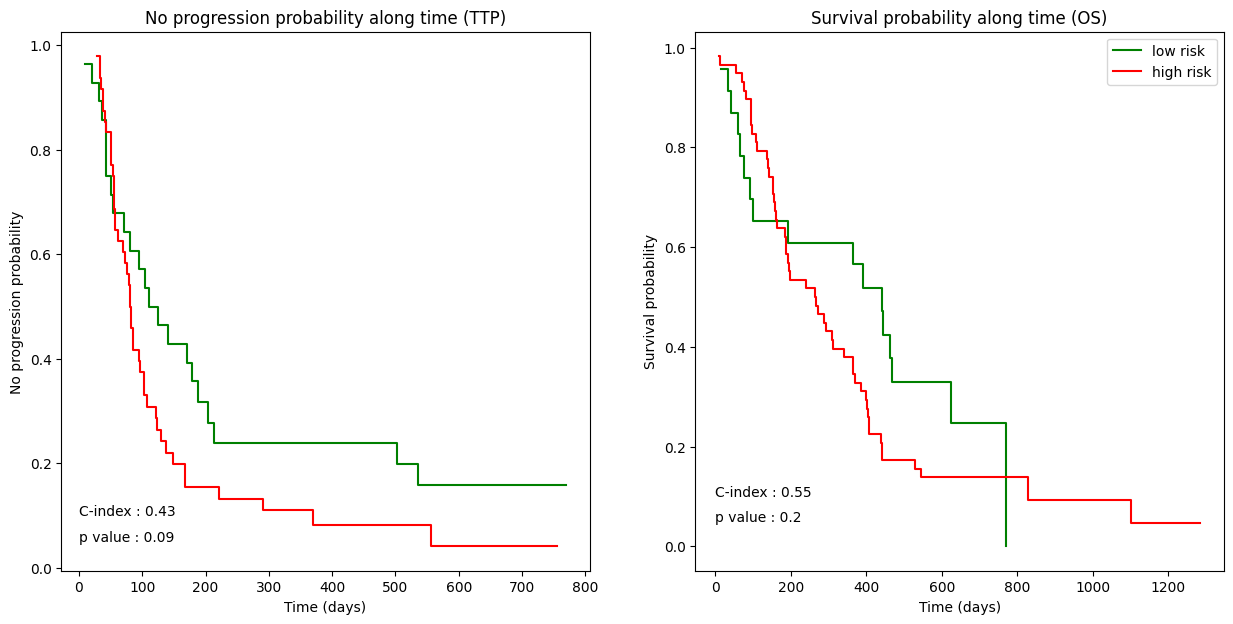

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].step(time_axis_low_ttp, prob_axis_low_ttp, where='post',color='green',label='low risk')
ax[0].step(time_axis_high_ttp, prob_axis_high_ttp, where='post',color='red',label='high risk')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('No progression probability')
ax[0].set_title('No progression probability along time (TTP)')
ax[0].text(0,0.1,f'C-index : {c_index_ttp}')
ax[0].text(0,0.05,f'p value : {p_value_ttp}')

ax[1].step(time_axis_low_os, prob_axis_low_os, where='post',color='green',label='low risk')
ax[1].step(time_axis_high_os, prob_axis_high_os, where='post',color='red',label='high risk')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Survival probability')
ax[1].set_title('Survival probability along time (OS)')
ax[1].text(0,0.1,f'C-index : {c_index_os}')
ax[1].text(0,0.05,f'p value : {p_value_os}')

plt.legend()
plt.savefig('gnn-cox-model-survival-curves.png')